## POS tagging using modified Viterbi

### Data Preparation

In [28]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random
from sklearn.model_selection import train_test_split

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents())

In [3]:
print(nltk_data[:5])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

2739
1175
[[('Campbell', 'NNP'), ('Soup', 'NNP'), ('jumped', 'VBD'), ('3', 'CD'), ('3\\/8', 'CD'), ('to', 'TO'), ('47', 'CD'), ('1\\/8', 'CD'), ('as', 'IN'), ('the', 'DT'), ('resignation', 'NN'), ('of', 'IN'), ('R.', 'NNP'), ('Gordon', 'NNP'), ('McGovern', 'NNP'), ('as', 'IN'), ('president', 'NN'), ('and', 'CC'), ('chief', 'NN'), ('executive', 'NN'), ('officer', 'NN'), ('sparked', 'VBD'), ('a', 'DT'), ('revival', 'NN'), ('of', 'IN'), ('rumors', 'NNS'), ('that', 'IN'), ('the', 'DT'), ('company', 'NN'), ('could', 'MD'), ('become', 'VB'), ('a', 'DT'), ('takeover', 'NN'), ('target', 'NN'), ('.', '.')], [('A', 'DT'), ('Waste', 'NNP'), ('Management', 'NNP'), ('spokeswoman', 'NN'), ('says', 'VBZ'), ('0', '-NONE-'), ('its', 'PRP$'), ('ad', 'NN'), ('in', 'IN'), ('the', 'DT'), ('premiere', 'NN'), ('issue', 'NN'), ('was', 'VBD'), ('a', 'DT'), ('one-time', 'JJ'), ('purchase', 'NN'), (',', ','), ('and', 'CC'), ('0', '-NONE-'), ('it', 'PRP'), ('does', 'VBZ'), ("n't", 'RB'), ('have', 'VB'), ('any', '

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70428

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Campbell', 'Soup', 'jumped', '3', '3\\/8', 'to', '47', '1\\/8', 'as', 'the']

In [7]:
# vocabulary
vocabulary = set(tokens)
print(len(vocabulary))

10327


In [8]:
# number of tags
tags = set([pair[1] for pair in train_tagged_words])
len(tags)

46

### Emission Probabilities

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(tags)
v = len(vocabulary)
w_given_t = np.zeros((t, v))

In [12]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [14]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [18]:
tags_matrix

array([[1.7903930e-02, 6.1863173e-02, 9.8107718e-02, ..., 3.1775838e-01,
        1.6011645e-03, 0.0000000e+00],
       [3.4002457e-02, 1.8394101e-01, 3.0315444e-02, ..., 2.0483409e-03,
        1.8844735e-02, 0.0000000e+00],
       [5.7093851e-02, 2.1318303e-02, 6.5670177e-02, ..., 3.9206077e-03,
        1.2251899e-02, 0.0000000e+00],
       ...,
       [9.1036418e-03, 2.3284314e-02, 2.0430672e-01, ..., 1.4005603e-03,
        1.7507003e-04, 2.4509805e-03],
       [5.1981807e-03, 6.2378168e-02, 3.3138402e-02, ..., 1.3580246e-01,
        0.0000000e+00, 0.0000000e+00],
       [7.4074075e-02, 0.0000000e+00, 6.6666669e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))

In [20]:
tags_df

,IN,CD,JJ,EX,#,VBZ,-RRB-,'',CC,PRP,...,NNPS,SYM,FW,UH,MD,VBN,:,DT,TO,RBS
IN,0.017904,0.061863,0.098108,0.001019,0.001310,0.000291,0.000000,0.000146,0.000873,0.031295,...,0.001601,0.000000,0.000000,0.000000,0.000000,0.003930,0.000146,0.317758,0.001601,0.000000
CD,0.034002,0.183941,0.030315,0.000000,0.000000,0.002458,0.000819,0.000819,0.011061,0.000819,...,0.000000,0.000000,0.000000,0.000000,0.002048,0.003277,0.004097,0.002048,0.018845,0.000000
JJ,0.057094,0.021318,0.065670,0.000000,0.000000,0.001225,0.000245,0.004411,0.016173,0.000245,...,0.001225,0.000000,0.000000,0.000000,0.000245,0.002695,0.002695,0.003921,0.012252,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.568965,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.051724,0.000000,0.000000,0.000000,0.000000,0.000000
#,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VBZ,0.086486,0.019595,0.072973,0.000000,0.000000,0.000676,0.000000,0.001351,0.004054,0.011486,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.159459,0.004730,0.139189,0.006757,0.000000
-RRB-,0.086420,0.012346,0.024691,0.000000,0.000000,0.024691,0.000000,0.000000,0.049383,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024691,0.012346,0.098765,0.086420,0.012346,0.000000
'',0.127349,0.004175,0.004175,0.004175,0.000000,0.144050,0.000000,0.008351,0.052192,0.089770,...,0.000000,0.000000,0.000000,0.000000,0.004175,0.002088,0.008351,0.106472,0.004175,0.000000
CC,0.055452,0.041745,0.095950,0.003738,0.000000,0.025545,0.000623,0.000000,0.000623,0.042368,...,0.001869,0.000000,0.000000,0.000000,0.010592,0.014953,0.000000,0.109657,0.006231,0.000000
PRP,0.033529,0.000000,0.005029,0.000000,0.000000,0.189438,0.000838,0.000000,0.007544,0.000838,...,0.000000,0.000000,0.000000,0.000000,0.134116,0.003353,0.003353,0.008382,0.018441,0.000000


In [21]:
tags_df.loc['.', :]

IN        0.115299
CD        0.006652
JJ        0.033999
EX        0.003695
#         0.000000
VBZ       0.001109
-RRB-     0.002587
''        0.056171
CC        0.049520
PRP       0.058758
RBR       0.000739
,         0.000000
NN        0.036955
PDT       0.000739
WP$       0.000000
VBD       0.000739
LS        0.001848
NNS       0.041390
VBG       0.002956
NNP       0.183666
VBP       0.000000
JJR       0.002587
-NONE-    0.022542
.         0.000000
WRB       0.006652
RB        0.041390
POS       0.000000
JJS       0.001848
-LRB-     0.004065
$         0.001109
WDT       0.000739
``        0.073910
RP        0.000000
PRP$      0.008500
WP        0.003326
VB        0.000739
NNPS      0.002956
SYM       0.000000
FW        0.000000
UH        0.000370
MD        0.000000
VBN       0.002217
:         0.002956
DT        0.225055
TO        0.001478
RBS       0.000370
Name: ., dtype: float32

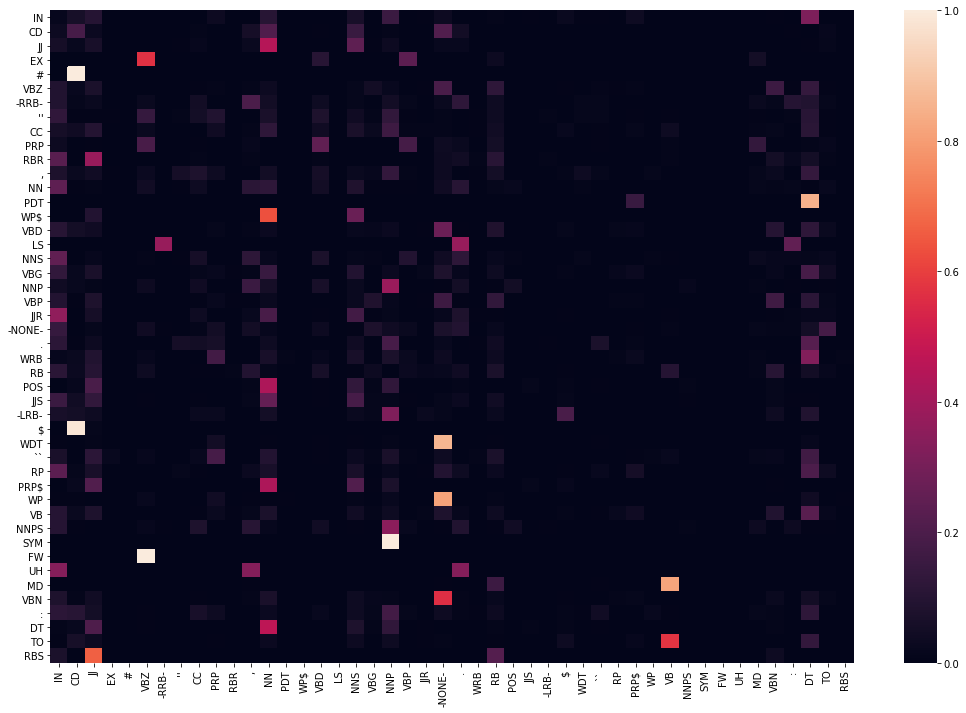

In [31]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

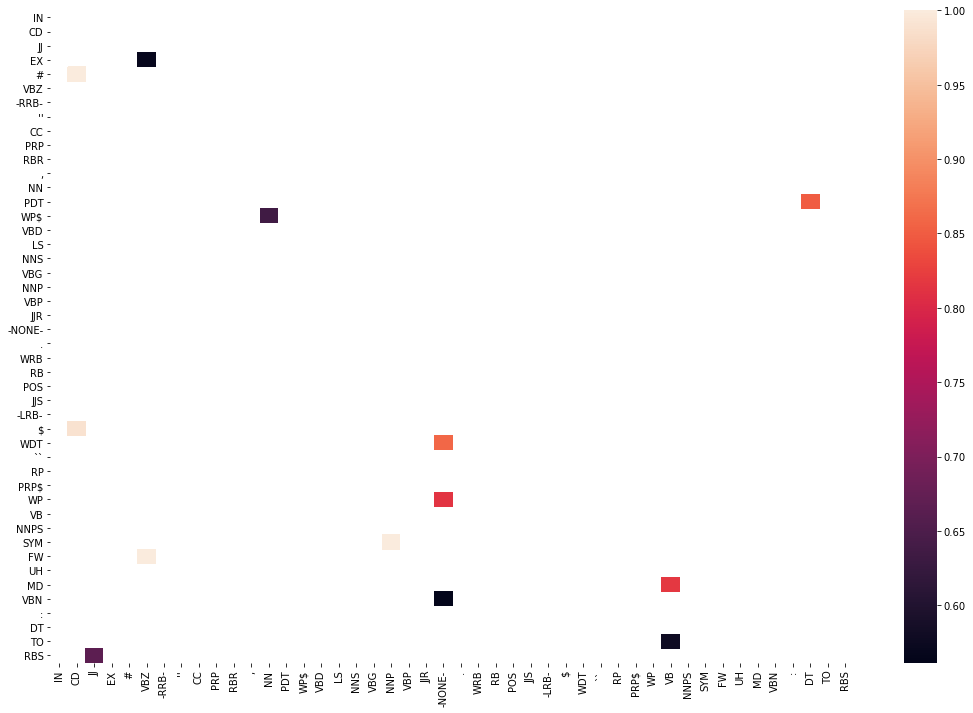

In [32]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [33]:
len(train_tagged_words)

70428

In [34]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications